# Programming Lenet5 with MindSpore

## 0. Configuring the Running Information

In [33]:
from mindspore import context

context.set_context(mode=context.GRAPH_MODE, device_target='CPU', enable_mem_reuse=False)

## 1. Downloading and preprocessing the Dataset
### Download the Dataset

In [ ]:
import os
import urllib.request
from urllib.parse import urlparse
import gzip

def unzipfile(gzip_path):
    open_file = open(gzip_path.replace('.gz',''), 'wb')
    gz_file = gzip.GzipFile(gzip_path)
    open_file.write(gz_file.read())
    gz_file.close()

def download_dataset():
    train_path = "./MNIST_Data/train/"
    test_path = "./MNIST_Data/test/"
    train_path_check = os.path.exists("./MNIST_Data/train/")
    test_path_check = os.path.exists("./MNIST_Data/test/")
    if train_path_check == False and test_path_check ==False:
        os.makedirs(train_path)
        os.makedirs(test_path)
    train_url = {"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"}
    test_url = {"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}
    for url in train_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(train_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)
    for url in test_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(test_path,url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz','')):
            file = urllib.request.urlretrieve(url, file_name)
            unzipfile(file_name)
            os.remove(file_name)

download_dataset()

### Processing Data

In [32]:
import mindspore.dataset.transforms.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.transforms.vision import Inter
from mindspore.common import dtype as mstype

import mindspore.dataset as ds


def processing_data(data_path, batch_size=32):

    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define operation parameters
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0
    rescale_nml = 1 / 0.3081
    shift_nml = -1 * 0.1307 / 0.3081

   # define map operations
    resize_op =      CV.Resize((resize_height, resize_width), interpolation=Inter.LINEAR)  # Resize images to (32, 32)
    rescale_nml_op = CV.Rescale(rescale_nml, shift_nml) # normalize images
    rescale_op =     CV.Rescale(rescale, shift) # rescale images
    hwc2chw_op =     CV.HWC2CHW() # change shape from (height, width, channel) to (channel, height, width) to fit network.
    type_cast_op =   C.TypeCast(mstype.int32) # change data type of label to int32 to fit network

    # apply map operations on images
    mnist_ds = mnist_ds.map(input_columns="label", operations=type_cast_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=resize_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=rescale_nml_op)
    mnist_ds = mnist_ds.map(input_columns="image", operations=hwc2chw_op)

    # apply DatasetOps
    mnist_ds = mnist_ds.shuffle(buffer_size=10000)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)

    return mnist_ds

ds_train = processing_data("./MNIST_Data/train", 32)
ds_eval  = processing_data("./MNIST_Data/test")


### Check the dataset
Aunque este no es un paso requerido para entrenar la red neuronal, sí que lo encuentro útil en este ejemplo con proposito pedagógico para que el lector o lectora vaya siguiendo que contienen las estructuras de datos que vamos manipulando. El siguiente código, usando la librería matplotlib, nos permite  visualizar cómo son los datos que tenemos en `ds_train` preparados para ser consumidos por la red neuronal. En concreto este código obtiene el primer batch de datos de 32 elementos, compuesto cada uno de ellos por una imagen y la etiqueta correspondiente, siendo mostrado por pantalla el primer de ellos (propongo al lector pruebe de modificar el código para investigar otros elementos o elementos de `ds_test`).


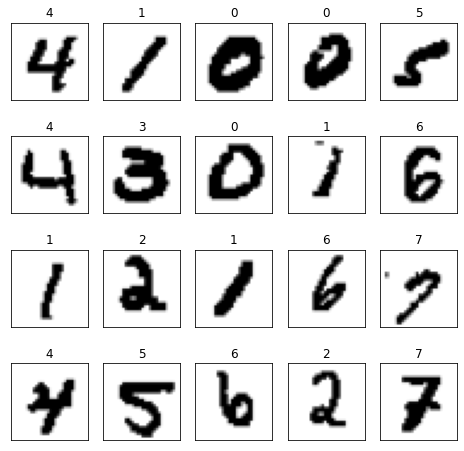

In [17]:
import numpy as np
import matplotlib.pyplot as plt

iterator = ds_train.create_dict_iterator()
item = next (iterator)

image = np.squeeze(item["image"],1)
label = item["label"]
    
fig = plt.figure(figsize=(8, 8))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 10/2, idx+1, xticks=[], yticks=[])
    ax.imshow(image[idx,:,:], cmap=plt.cm.binary)
    ax.set_title(str(label[idx]))


## 2. Defining the Model

In [24]:
import mindspore.nn as nn
import mindspore.ops.operations as P

from mindspore.common.initializer import TruncatedNormal

def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.batch_size = 32
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, 
#                               stride=1, padding=0,
                               weight_init=weight_variable(), has_bias=False, 
                               pad_mode="valid"
                              )
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, 
#                               stride=1, padding=0,
                               weight_init=weight_variable(),has_bias=False, 
                               pad_mode="valid"
                              )
        self.fc1 =  nn.Dense(in_channels= 16 * 5 * 5, out_channels= 120 ,weight_init= weight_variable(),bias_init=weight_variable())
        self.fc2 =  nn.Dense(in_channels= 120,  out_channels= 84,weight_init=weight_variable(),bias_init=weight_variable())
        self.fc3 =  nn.Dense(in_channels=  84, out_channels= 10,weight_init=weight_variable(),bias_init=weight_variable())
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.reshape = P.Reshape()

    # use the preceding operators to construct networks
    # Es com el One forward pass through the network de PyTorch --> def forward(self, x):
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.reshape(x, (self.batch_size, -1))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    
network = LeNet5()

# Explicar que també té de predefinides
#from mindspore.model_zoo.lenet import LeNet5
#network = LeNet5(10)

## 3. Configuring the learning process
### Defining the Loss Function and Optimizer

Loss functions supported by MindSpore include SoftmaxCrossEntropyWithLogits, L1Loss, MSELoss. The loss function SoftmaxCrossEntropyWithLogits is used in this example.


Segons la documentació Optimizers supported by MindSpore include Adam, AdamWeightDecay and Momentum. Però només m'ha funcionat aquesta: 
The popular Momentum optimizer is used in this example. 



In [25]:
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
from mindspore.nn import Momentum

criterion = SoftmaxCrossEntropyWithLogits(is_grad=False, sparse=True, reduction='mean')
# a optimizer sobra el nn.
optimizer = nn.Momentum(params=network.trainable_params(), learning_rate=0.01, momentum=0.9)

## 4. Training the Network
### Saving the Configured Model

MindSpore provides the callback mechanism to execute customized logic during training (Abstract base class used to build a callback function (Callback function will execution some operating to the current step or epoch.). `ModelCheckpoint` and `LossMonitor` provided by the framework are used in this example. ModelCheckpoint can save network models and parameters for subsequent fine-tuning. LossMonitor can monitor the changes of the loss value during training.

The checkpoint callback class. It is called to combine with train process and save the model and network parameters after traning.

sobre els parametres:
save_checkpoint_steps indicates the saving frequency. That is, parameters are saved every specified number of steps. keep_checkpoint_max indicates the maximum number of CheckPoint files that can be saved. prefix indicates the prefix name of the generated CheckPoint file. directory indicates the directory for storing the file. Create a ModelCheckpoint object and transfer it to the model.train method. Then you can use the CheckPoint function during training.


In [26]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
# solo hacemos una pasada por los datos epochs=
epochs = 1


config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
# dir que són 60000 / 32 = 1875 iteracions 

# save the network model and parameters for subsequence fine-tuning

ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)



### Calling the High-level Model API To Train and Save the Model File

After data preprocessing, network definition, and loss function and optimizer definition are complete, model training can be performed. Model training involves two iterations: multi-round iteration (epoch) of datasets and single-step iteration based on the batch size of datasets. The single-step iteration refers to extracting data from a dataset by batch, inputting the data to a network to calculate a loss function, and then calculating and updating a gradient of training parameters by using an optimizer.
To simplify the training process, MindSpore encapsulates the high-level Model API. You can enter the network, loss function, and optimizer to complete the Model initialization, and then call the train API for training. The train API parameters include the number of iterations (epoch) and dataset (dataset).
Model saving is a process of persisting training parameters. In the Model class, the model is saved using the callback function, as shown in the following code: You can set the parameters of the callback function by using CheckpointConfig. save_checkpoint_steps indicates that the model is saved once every fixed number of single-step iterations, and keep_checkpoint_max indicates the maximum number of saved models.

In [27]:

from mindspore.nn.metrics import Accuracy

from mindspore.train import Model

# group layers into an object with training and evaluation features
model = Model(network, criterion, optimizer, metrics={"Accuracy": Accuracy()})

In [28]:
!rm -r checkpoint_lenet*

rm: cannot remove 'checkpoint_lenet*': No such file or directory


In [29]:

#ds_train = processing_data(os.path.join(mnist_path, "train"), 32)
model.train(epochs, ds_train, callbacks=[ckpoint_cb, LossMonitor()], dataset_sink_mode=False)


epoch: 1 step: 1, loss is 2.3029177
epoch: 1 step: 2, loss is 2.3009098
epoch: 1 step: 3, loss is 2.3022113
epoch: 1 step: 4, loss is 2.3016534
epoch: 1 step: 5, loss is 2.307083
epoch: 1 step: 6, loss is 2.306141
epoch: 1 step: 7, loss is 2.2998662
epoch: 1 step: 8, loss is 2.2990673
epoch: 1 step: 9, loss is 2.3111722
epoch: 1 step: 10, loss is 2.3025305
epoch: 1 step: 11, loss is 2.302836
epoch: 1 step: 12, loss is 2.3026507
epoch: 1 step: 13, loss is 2.3043838
epoch: 1 step: 14, loss is 2.3068862
epoch: 1 step: 15, loss is 2.3000393
epoch: 1 step: 16, loss is 2.2964983
epoch: 1 step: 17, loss is 2.3028107
epoch: 1 step: 18, loss is 2.3064792
epoch: 1 step: 19, loss is 2.3073158
epoch: 1 step: 20, loss is 2.3025804
epoch: 1 step: 21, loss is 2.3002098
epoch: 1 step: 22, loss is 2.3025649
epoch: 1 step: 23, loss is 2.2989902
epoch: 1 step: 24, loss is 2.3019745
epoch: 1 step: 25, loss is 2.3035905
epoch: 1 step: 26, loss is 2.2983718
epoch: 1 step: 27, loss is 2.304923
epoch: 1 step:

## 5. Model Evaluation

After saving CheckPoint files, you can load parameters.
For Inference Validation

In inference-only scenarios, use load_checkpoint to directly load parameters to the network for subsequent inference validation.

The load_checkpoint method loads network parameters in the parameter file to the model. After the loading, parameters in the network are those saved in CheckPoints. The eval method validates the accuracy of the trained model.

The load_checkpoint method returns a parameter dictionary and then the load_param_into_net method loads parameters in the parameter dictionary to the network or optimizer.


In [30]:
!ls

First_Contact_with_MindSpore_10Apr2020_darrer-3.ipynb  etc    root
MNIST_Data					       home   run
analyze_fail.dat				       lib    sbin
bin						       lib64  srv
boot						       media  sys
checkpoint_lenet-1_1875.ckpt			       mnt    tmp
checkpoint_lenet-graph.meta			       opt    usr
dev						       proc   var


In [31]:
## Evaluación notebook

from mindspore.train.serialization import load_checkpoint, load_param_into_net

# load the saved model for evaluation
param_dict = load_checkpoint("checkpoint_lenet-1_1875.ckpt")
# load parameter to the network
load_param_into_net(network, param_dict)
# load testing dataset
acc = model.eval(ds_eval, dataset_sink_mode=False)
print("{}".format(acc))

{'Accuracy': 0.9510216346153846}
